In [1]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx
import ECOS
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using MeshCat
const mc = MeshCat
using StaticArrays
using Printf
using CSV
using Tables

  Activating environment at `~/Documents/CMU/Research/Delta-Robot/delta_walker/ocrl/Project.toml`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))

fmincon (generic function with 1 method)

**NOTE: This question will have long outputs for each cell, remember you can use `cell -> all output -> toggle scrolling` to better see it all**

# Q2: Hybrid Trajectory Optimization  (60 pts)
In this problem you'll use a direct method to optimize a walking trajectory for a simple biped model, using the hybrid dynamics formulation. You'll pre-specify a gait sequence and solve the problem using Ipopt. Your final solution should look like the video above.

## The Dynamics
Our system is modeled as three point masses: one for the body and one for each foot. The state is defined as the x and y positions and velocities of these masses, for a total of 6 degrees of freedom and 12 states. We will label the position and velocity of each body with the following notation:
$$ \begin{align}
r^{(b)} &= \begin{bmatrix} p_x^{(b)} \\ p_y^{(b)} \end{bmatrix} & v^{(b)} &= \begin{bmatrix} v_x^{(b)} \\ v_y^{(b)} \end{bmatrix}\\
r^{(1)} &= \begin{bmatrix} p_x^{(1)} \\ p_y^{(1)} \end{bmatrix} & v^{(1)} &= \begin{bmatrix} v_x^{(1)}\\
v_y^{(1)} \end{bmatrix}\\
r^{(2)} &= \begin{bmatrix} p_x^{(2)} \\ p_y^{(2)} \end{bmatrix} & v^{(2)} &= \begin{bmatrix} v_x^{(2)}\\
v_y^{(2)} \end{bmatrix}
\end{align}$$
Each leg is connected to the body with prismatic joints. The system has three control inputs: a force along each leg, and the torque between the legs.

The state and control vectors are ordered as follows:

$$ x = \begin{bmatrix}
    p_x^{(b)} \\ p_y^{(b)} \\ p_x^{(1)} \\ p_y^{(1)} \\ p_x^{(2)} \\ p_y^{(2)} \\
    v_x^{(b)} \\ v_y^{(b)} \\ v_x^{(1)} \\ v_y^{(1)} \\ v_x^{(2)} \\ v_y^{(2)} \\
\end{bmatrix} \quad
u = \begin{bmatrix} F^{(1)} \\ F^{(2)} \\ \tau \end{bmatrix}
$$
where e.g. $p_x^{(b)}$ is the $x$ position of the body, $v_y^{(i)}$ is the $y$ velocity of foot $i$, $F^{(i)}$ is the force along leg $i$, and $\tau$ is the torque between the legs.

The continuous time dynamics and jump maps for the two stances are shown below:

In [3]:
COM_OFFSET = 0.02


0.02

In [4]:
# body is 400 g, and feet are 25 g each
function dynamics(model::NamedTuple, x::Vector, u::Vector, λ::Vector)
    mb,mf = model.mb, model.mf # body is 400 g, and feet are 25 g each
    g = model.g

    I_3 = Matrix(I, 3, 3)
    M = Diagonal([mb,mb,mb,mf,mf,mf,mf,mf,mf,mf,mf,mf,mf,mf,mf])

    v = x[16:30]

    B = vcat(-[I_3 I_3 I_3 I_3], Matrix(I,12,12))

    C = vcat(zeros(3,12), Matrix(I,12,12))

    v̇ = M\[0; 0; -mb*g; 0; 0; -mf*g; 0; 0; -mf*g; 0; 0; -mf*g; 0; 0;-mf*g] + M\B*u + M\C*λ

    ẋ = [v; v̇]

    return ẋ
end

function rk4(model::NamedTuple, ode::Function, x::Vector, u::Vector, λ::Vector, dt::Real)::Vector
    k1 = dt * ode(model, x,        u, λ)
    k2 = dt * ode(model, x + k1/2, u, λ)
    k3 = dt * ode(model, x + k2/2, u, λ)
    k4 = dt * ode(model, x + k3,   u, λ)
    return x + (1/6)*(k1 + 2*k2 + 2*k3 + k4)
end

rk4 (generic function with 1 method)

In [5]:
#static equilibrium
g = 9.81
mb = 0.4;
mf = 0.025;
gvec = [0;0;-g;0;0;-g;0;0;-g;0;0;-g]
uvec = [0;0;-mb*g/4;0;0;-mb*g/4;0;0;-mb*g/4;0;0;-mb*g/4]
λvec = [0;0;(mb/4+mf)*g;0;0;(mb/4+mf)*g;0;0;(mb/4+mf)*g;0;0;(mb/4+mf)*g];

xic_b = [0    ; 0   ; 0.05 + COM_OFFSET]  #TODO check
xic_1 = [ 0.04; 0   ; 0.00]
xic_2 = [0    ; 0.04; 0.00]
xic_3 = [-0.04; 0   ; 0.00]
xic_4 = [0    ;-0.04; 0.00]
vic_b = [0; 0; 0]
vic_1 = [0; 0; 0]
vic_2 = [0; 0; 0]
vic_3 = [0; 0; 0]
vic_4 = [0; 0; 0]
xic = vcat(xic_b, xic_1, xic_2, xic_3, xic_4, vic_b, vic_1, vic_2, vic_3, vic_4)

model = (mb = mb, mf = mf, g = g)
println(dynamics(model, xic, uvec, λvec))

println(xic - rk4(model, dynamics, xic, uvec, λvec, 0.05))

# c[idx.c[k]] = xk1 - rk4(model, dynamics,  xk,   uk,   λk,   dt)


# xk = Z[idx.x[k]]
# uk = Z[idx.u[k]]
# λk = Z[idx.λ[k]]
# xk1 = Z[idx.x[k+1]]
# c[idx.c[k]] = xk1 - rk4(model, dynamics, xk, uk, λk, dt)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


To solve this problem with Ipopt and `fmincon`, we are going to concatenate all of our $x$'s and $u$'s into one vector (same as HW3Q1):

$$ Z = \begin{bmatrix}x_1 \\ u_1 \\ x_2 \\ u_2 \\ \vdots \\ x_{N-1} \\ u_{N-1} \\ x_N \end{bmatrix} \in \mathbb{R}^{N \cdot nx + (N-1)\cdot nu} $$

where $x \in \mathbb{R}^{nx}$ and $u \in \mathbb{R}^{nu}$. Below we will provide useful indexing guide in `create_idx` to help you deal with $Z$.  Remember that the API for `fmincon` (that we used in HW3Q1) is the following:
$$ \begin{align} \min_{z} \quad & \ell(z) & \text{cost function}\\
 \text{st} \quad & c_{eq}(z) = 0 & \text{equality constraint}\\
 & c_L \leq c_{ineq}(z) \leq c_U & \text{inequality constraint}\\
 & z_L \leq z \leq z_U & \text{primal bound constraint}
 \end{align}$$

 Template code has been given to solve this problem but you should feel free to do whatever is easiest for you, as long as you get the trajectory shown in the animation `walker.gif` and pass tests.

By introducing a dual variable $\lambda \in \mathbb{R}^m$ for the equality constraint, and $\mu \in \mathbb{R}^p$ for the inequality constraint, we have the following KKT conditions for optimality:

$$ \begin{align} \min_{x_{1:N},u_{1:N-1}} \quad & J(x_{1:N},u_{1:N-1}) & \\
 \text{st} \quad &  x_1 = x_{ic} \\
 \quad & x_N = x_{g} \\
 x_{k+1} &= rk4(dynamics(x_k,u_k,\lambda_k)) \quad \quad \text{for } k \in [1, N-1] \\
 \lambda^{(i)}_z&\geq 0 \quad \quad \forall i \in [1,2,3,4] \text{pushing forces only}\\
 u^{(i)}_z&\geq 0 \quad \quad \forall i \in [1,2,3,4]  \text{pushing forces only}\\
 ||\lambda^{(i)}||_2&> 0 \quad \quad \text{  if  } x_z^i= 0 \forall i \in [1,2,3,4]  \text{  contact ineq constraint } \\
 ||v_k^{(i)}||_2 & = 0 \quad \quad \text{  if  } x_z^i= 0 \forall i \in [1,2,3,4]  \text{  contact eq constraint } \\
 x_z^i &> 0 \quad \quad \text{  if  } ||\lambda^i||_2= 0 \forall i \in [1,2,3,4] \text{  floating ineq constraint } \\
 x^{(b)}_z, x^{(1)}_z, x^{(2)}_z, x^{(3)}_z, x^{(4)}_z&\geq 0 \quad \quad \text{minimum z height} \\
 x^{(b)}_z&\leq 0.06 \quad \quad \text{body z height < 0.06 (redundant? constraind by end effector behavior)} \\
 \text{Jon} &= 0 \quad \quad \text{end effector positional constraints} \\
 ||v_k^{(i)}||_2 & \leq 0.015 \quad \quad \forall i \in [1,2,3,4]  \text{  end effector velocity constraints} \\
 &= 0 \quad \quad \text{3 feet need to touch the ground at any given time} \\
 &= djfalkdjfalkdj \quad \quad \text{COG in support polygon formed by 3 feet need to contain the COG} \\
 &\leq djfalkdjfalkdj \quad \quad \text{COG tolerance in support polygon formed by 3 feet need to contain the COG} \\
 &= 0 \quad \quad \text{end effectors on ground are fixed (?)} \\
 &= 0 \quad \quad \text{M1,M2,M3,M4 force constraints lambda and u constraints} \\
\end{align}$$ 


In [6]:
# feel free to solve this problem however you like, below is a template for a
# good way to start.

# NOTE: create M1,M2,M3,M4
function createMs(tduration,dt,N) #---------------------------------------------------------------------------------------------------------------------------------------------------
    # tduration - duration in sec for a foot in air
    # dt - simulation dt
    # N - simulation N steps
    dN = Int64(round(tduration / dt))

    # M1 = vcat([ (i-1)*10      .+ (1:5)   for i = 1:5]...) # stack the set into a vector
    # M2 = vcat([((i-1)*10 + 5) .+ (1:5)   for i = 1:4]...) # stack the set into a vector
    # order of feet up: 1 2 3 4
    M0 = vcat([ (i-1)*8*dN         .+ (1:dN) for i = 1:Int64(floor(N/dN/8))]...)
    M1 = vcat([((i-1)*8*dN + dN)   .+ (1:dN) for i = 1:Int64(floor(N/dN/8))]...)
    M0 = sort(vcat(M0, [((i-1)*8*dN + 2*dN) .+ (1:dN) for i = 1:Int64(floor(N/dN/8))]...))
    M2 = vcat([((i-1)*8*dN + 3*dN) .+ (1:dN) for i = 1:Int64(floor(N/dN/8))]...)
    M0 = sort(vcat(M0, [((i-1)*8*dN + 4*dN) .+ (1:dN) for i = 1:Int64(floor(N/dN/8))]...))
    M3 = vcat([((i-1)*8*dN + 5*dN) .+ (1:dN) for i = 1:Int64(floor(N/dN/8))]...)
    M0 = sort(vcat(M0, [((i-1)*8*dN + 6*dN) .+ (1:dN) for i = 1:Int64(floor(N/dN/8))]...))
    M4 = vcat([((i-1)*8*dN + 7*dN) .+ (1:dN) for i = 1:Int64(floor(N/dN/8))]...)
    
    newN = Int64(floor(N/dN/8)) * dN * 8

    return M0, M1, M2, M3, M4, newN
end

# NOTE: our idxs
function create_idx(nx,nu,nλ,N)
    # create idx for indexing convenience
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    # and stacked dynamics constraints of size nx are
    # c[idx.c[i]] = <dynamics constraint at time step i>
    #
    # feel free to use/not use this

    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + (N-1) * nλ + N * nx # length of Z
    x = [(i - 1) * (nx + nu + nλ) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu + nλ) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    λ = [(i - 1) * (nx + nu + nλ) .+ ((nx + nu + 1):(nx + nu + nλ)) for i = 1:(N-1)]

    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx

    return (nx=nx,nu=nu,nλ=nλ,N=N,nz=nz,nc=nc,x=x,u=u,λ=λ,c=c)
end

# NOTE:  delta robot dyanamics constraints
function walker_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    model = params.model

    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)

    # TODO: input walker dynamics constraints (constraints 3-6 in the opti problem)
    for k = 1:N-1
        xk = Z[idx.x[k]]
        uk = Z[idx.u[k]]
        λk = Z[idx.λ[k]]
        xk1 = Z[idx.x[k+1]]
        c[idx.c[k]] = xk1 - rk4(model, dynamics, xk, uk, λk, dt)
    end
    return c
end

# NOTE: end effector velocity constraint
function velocity_ineq_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    model = params.model

    c = zeros(eltype(Z), 4*(N))

    v_lim = 0.015; # 15mm/s
    for k = 1:(N)
        xk = Z[idx.x[k]]
        c[4*k - 3] = v_lim - norm(xk[19:21])
        c[4*k - 2] = v_lim - norm(xk[22:24])
        c[4*k - 1] = v_lim - norm(xk[25:27])
        c[4*k]     = v_lim - norm(xk[28:30])
    end

    return c # >= 0
end

function position_ineq_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    # M1, M2 = params.M1, params.M2

    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), 12*N)

    for k = 1:N
        rbk = Z[idx.x[k]][1:3]
        r1k = Z[idx.x[k]][4:6]
        r2k = Z[idx.x[k]][7:9]
        r3k = Z[idx.x[k]][10:12]
        r4k = Z[idx.x[k]][13:15]

        rak = copy(rbk) - [0, 0, COM_OFFSET]

        # sets positions of actuator bases
        ra1k = copy(rak) # DOES ROBOT EVER ROTATE?
        ra1k[1] += 0.04
        ra2k = copy(rak)
        ra2k[2] += 0.04
        ra3k = copy(rak)
        ra3k[1] += -0.04
        ra4k = copy(rak)
        ra4k[2] += -0.04

        z_offset1 = ra1k[3] - 0.048 #- 0.01  # TODO check this
        z_offset2 = ra2k[3] - 0.048 #- 0.01
        z_offset3 = ra3k[3] - 0.048 #- 0.01 
        z_offset4 = ra4k[3] - 0.048 #- 0.01

        c[12*k - 11] = 0.0135 - norm(ra1k[1:2] - r1k[1:2])
        c[12*k - 10] = r1k[3] - z_offset1 + 0.0025
        c[12*k - 9] = z_offset1 + 0.0075 - r1k[3]

        c[12*k - 8] = 0.0135 - norm(ra2k[1:2] - r2k[1:2])
        c[12*k - 7] = r2k[3] - z_offset2 + 0.0025
        c[12*k - 6] = z_offset2 + 0.0075 - r2k[3]

        c[12*k - 5] = 0.0135 - norm(ra3k[1:2] - r3k[1:2])
        c[12*k - 4] = r3k[3] - z_offset3 + 0.0025
        c[12*k - 3] = z_offset3 + 0.0075 - r3k[3]

        c[12*k - 2] = 0.0135 - norm(ra4k[1:2] - r4k[1:2])
        c[12*k - 1] = r4k[3] - z_offset4 + 0.0025
        c[12*k - 0] = z_offset4 + 0.0075 - r4k[3]

    end

    return c

end

function body_torque_eq_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt

    c = zeros(eltype(Z), 3*N)

    for k in 1:N-1
        xk = Z[idx.x[k+1]]
        body = xk[1:3] 
        foot1 = xk[4:6]
        foot2 = xk[7:9]
        foot3 = xk[10:12]
        foot4 = xk[13:15]
    
        uk = Z[idx.u[k]]
        u1 = uk[1:3]
        u2 = uk[4:6]
        u3 = uk[7:9]
        u4 = uk[10:12]

        # skew_symmetric = [0 -xk[3] xk[2]; xk[3] 0 -xk[1]; -xk[2] xk[1] 0];
        # c[(3*k-2):(3*k)] = (skew_symmetric * foot1) + (skew_symmetric * foot2) + (skew_symmetric * foot3) + (skew_symmetric * foot4)
        c[(3*k-2):(3*k)] = cross(u1,foot1-body) + cross(u2,foot2-body) + cross(u3,foot3-body) + cross(u4,foot4-body)
    end

    return c
end


body_torque_eq_constraint (generic function with 1 method)

In [7]:
# NOTE: our cost function that we minimize
function walker_cost(params::NamedTuple, Z::Vector)::Real
    # cost function
    idx, N, xg, model = params.idx, params.N, params.xg, params.model
    # Q, R, Qf = params.Q, params.R, params.Qf
    # Xref,Uref = params.Xref, params.Uref

    # TODO: input walker LQR cost
    J = 0
    for i = 1:N-1
        # u_i = Z[idx.u[i]]
        # u1adj = [u_i[1] u_i[2]  u_i[3] +(model.mb/4 + model.mf) * model.g]
        # u2adj = [u_i[4] u_i[5]  u_i[6] +(model.mb/4 + model.mf) * model.g]
        # u3adj = [u_i[7] u_i[8]  u_i[9] +(model.mb/4 + model.mf) * model.g]
        # u4adj = [u_i[9] u_i[11] u_i[12]+(model.mb/4 + model.mf) * model.g]
        # J += norm(u1adj)^2 + norm(u2adj)^2 + norm(u3adj)^2 + norm(u4adj)^2
        xk = Z[idx.x[i]]
        J += norm(xk-xg)^2
    end

    return J
end

function walker_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg

    dynamics_constraints = walker_dynamics_constraints(params, Z)
    body_torque_constraint = body_torque_eq_constraint(params, Z)

    equality_constraints = vcat(dynamics_constraints) #,body_torque_constraint) 

    return equality_constraints
end

function walker_inequality_constraint(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    velocity_constraint = velocity_ineq_constraint(params, Z) # 4*N  c_ineq >= 0
    position_constraint = position_ineq_constraint(params,Z) # 12*N
    inequality_constraints = vcat(velocity_constraint,position_constraint)
    return inequality_constraints
end

walker_inequality_constraint (generic function with 1 method)

2136hi2136hi---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:  2428920
Number of nonzeros in inequality constraint Jacobian.:  1328640
Number of nonzeros in Lagrangia

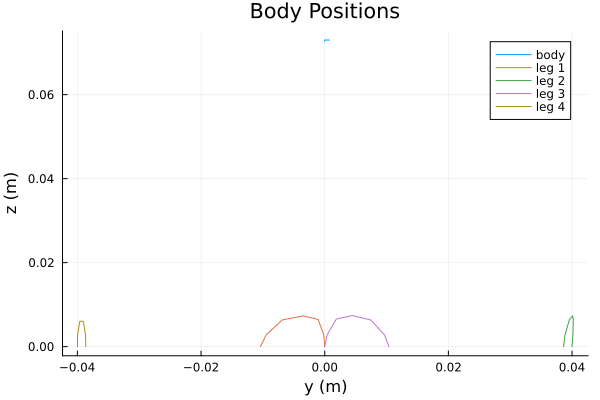

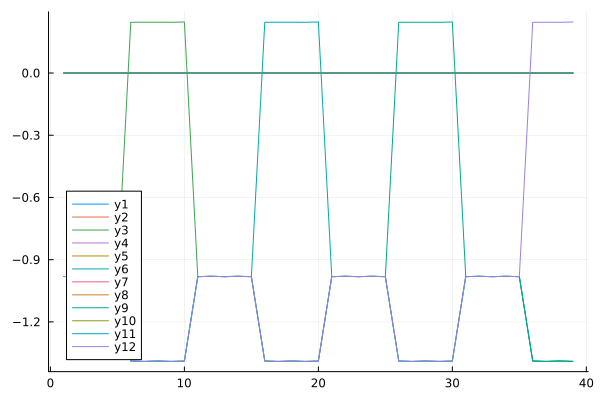

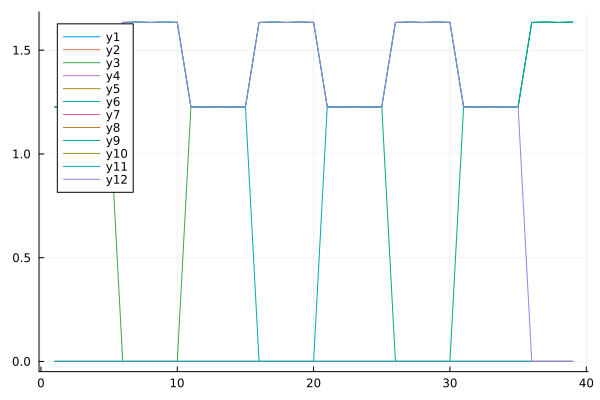

In [8]:
# dynamics parameters  # body is 400 g, and feet are 25 g each
model = (g = 9.81, mb= 0.400, mf = 0.025)

# problem size
nx = 6*5
nu = 3*4
nλ = 3*4
tf = 16
dt = 0.4
t_vec = 0:dt:tf
N = length(t_vec)

# adjustable: goal pos---------------------------------------------------------------------------------------------------------------------------------------------------
step = 0;
goal_x = 0;
goal_y = 0;

theta = deg2rad(-15)
dsin = 0.04*sin(theta)
dcos = 0.04 - 0.04*cos(theta)

# initial state
xic_b = [ 0.00 ;  0.00 ; 0.0527 + COM_OFFSET] # 0.058  # TODO check this
xic_1 = [ 0.04 ;  0.00 ; 0.00]
xic_2 = [ 0.00 ;  0.04 ; 0.00]
xic_3 = [-0.04 ;  0.00 ; 0.00]
xic_4 = [ 0.00 ; -0.04 ; 0.00]
vic_b = [0; 0; 0]
vic_1 = [0; 0; 0]
vic_2 = [0; 0; 0]
vic_3 = [0; 0; 0]
vic_4 = [0; 0; 0]
xic = vcat(xic_b, xic_1, xic_2, xic_3, xic_4, vic_b, vic_1, vic_2, vic_3, vic_4)
# goal state
xg_b = [goal_x              ; goal_y       ; 0.0527 + COM_OFFSET] # 0.058  # TODO check this
xg_1 = [goal_x + 0.04 - dcos; goal_y        + dsin; 0.00]
xg_2 = [goal_x        - dsin; goal_y + 0.04 - dcos; 0.00]
xg_3 = [goal_x - 0.04 + dcos; goal_y        - dsin; 0.00]
xg_4 = [goal_x        + dsin; goal_y - 0.04 + dcos; 0.00]
vg_b = [0; 0; 0]
vg_1 = [0; 0; 0]
vg_2 = [0; 0; 0]
vg_3 = [0; 0; 0]
vg_4 = [0; 0; 0]
xg =  vcat(xg_b, xg_1, xg_2, xg_3, xg_4, vg_b, vg_1, vg_2, vg_3, vg_4)

# index sets
M0,M1,M2,M3,M4,N = createMs(2,dt,N)

# LQR cost function (tracking Xref, Uref)
Q = diagm([1; 10; fill(1.0, 4); 1; 10; fill(1.0, 4)]);
R = diagm(fill(1e-3,3))
Qf = 1*Q;

# create indexing utilities
idx = create_idx(nx,nu,nλ,N)

# put everything useful in params
# error("Update params = (... )")
params = (
    model = model,
    nx = nx,
    nu = nu,
    nλ = nλ,
    tf = tf,
    dt = dt,
    t_vec = t_vec,
    N = N,
    eps = 1e-4,
    M0 = M0,
    M1 = M1,
    M2 = M2,
    M3 = M3,
    M4 = M4,
    xic = xic,
    xg = xg,
    idx = idx,
    Q = Q, R = R, Qf = Qf,
)

# TODO: primal bounds (constraint 11)
x_l = -Inf*ones(idx.nz) 
x_u =  Inf*ones(idx.nz) 

for i = 1:N
    # min body and feet z-height
    x_l[idx.x[i][3]] = 0.053 + COM_OFFSET # TODO check this
    x_l[idx.x[i][6]] = 0
    x_l[idx.x[i][9]] = 0
    x_l[idx.x[i][12]] = 0
    x_l[idx.x[i][15]] = 0
    # max body and feet z-height
    x_u[idx.x[i][3]] = 0.0605 + COM_OFFSET # TODO check this
    # x_u[idx.x[i][6]] = 0
    # x_u[idx.x[i][9]] = 0
    # x_u[idx.x[i][12]] = 0
    # x_u[idx.x[i][15]] = 0

    # grounded foot velocity constraint to 0
    grounded_vel = 2e-8
    if i in M0 # all feet grounded
        x_l[idx.x[i][19:30]] .= -grounded_vel
        x_u[idx.x[i][19:30]] .= grounded_vel
    elseif i in M1 # feet _, 2, 3, 4 grounded
        x_l[idx.x[i][22:30]] .= -grounded_vel
        x_u[idx.x[i][22:30]] .= grounded_vel
    elseif i in M2 # feet 1, _, 3, 4 grounded
        x_l[idx.x[i][19:21]] .= -grounded_vel
        x_u[idx.x[i][19:21]] .= grounded_vel
        x_l[idx.x[i][25:30]] .= -grounded_vel
        x_u[idx.x[i][25:30]] .= grounded_vel
    elseif i in M3 # feet 1, _, 3, 4 grounded
        x_l[idx.x[i][19:24]] .= -grounded_vel
        x_u[idx.x[i][19:24]] .= grounded_vel
        x_l[idx.x[i][28:30]] .= -grounded_vel
        x_u[idx.x[i][28:30]] .= grounded_vel
    elseif i in M4 # feet 1, _, 3, 4 grounded
        x_l[idx.x[i][19:27]] .= -grounded_vel
        x_u[idx.x[i][19:27]] .= grounded_vel
    end

    # # floating foot z>0 constraint
    z_height_tol = 2.5e-4
    # if i in M0 # all feet grounded
    #     # no constraint
    # elseif i in M1 # feet 1 floating
    #     x_l[idx.x[i][6]] = z_height_tol
    # elseif i in M2 # feet 2 floating
    #     x_l[idx.x[i][9]] = z_height_tol
    # elseif i in M3 # feet 3 floating
    #     x_l[idx.x[i][12]] = z_height_tol
    # elseif i in M4 # feet 4 floating
    #     x_l[idx.x[i][15]] = z_height_tol
    # end

    # grounded foot z=0 constraint 
    if i in M0 # all feet grounded
        x_l[idx.x[i][6]] = 0
        x_u[idx.x[i][6]] = z_height_tol/2
        x_l[idx.x[i][9]] = 0
        x_u[idx.x[i][9]] = z_height_tol/2
        x_l[idx.x[i][12]] = 0
        x_u[idx.x[i][12]] = z_height_tol/2
        x_l[idx.x[i][15]] = 0
        x_u[idx.x[i][15]] = z_height_tol/2
    elseif i in M1 # feet 1 floating
        x_l[idx.x[i][9]] = 0
        x_u[idx.x[i][9]] = z_height_tol/2
        x_l[idx.x[i][12]] = 0
        x_u[idx.x[i][12]] = z_height_tol/2
        x_l[idx.x[i][15]] = 0
        x_u[idx.x[i][15]] = z_height_tol/2

        x_l[idx.x[i][6]] = z_height_tol
    elseif i in M2 # feet 2 floating
        x_l[idx.x[i][6]] = 0
        x_u[idx.x[i][6]] = z_height_tol/2
        x_l[idx.x[i][12]] = 0
        x_u[idx.x[i][12]] = z_height_tol/2
        x_l[idx.x[i][15]] = 0
        x_u[idx.x[i][15]] = z_height_tol/2

        x_l[idx.x[i][9]] = z_height_tol
    elseif i in M3 # feet 3 floating
        x_l[idx.x[i][6]] = 0
        x_u[idx.x[i][6]] = z_height_tol
        x_l[idx.x[i][9]] = 0
        x_u[idx.x[i][9]] = z_height_tol
        x_l[idx.x[i][15]] = 0
        x_u[idx.x[i][15]] = z_height_tol

        x_l[idx.x[i][12]] = z_height_tol/2
    elseif i in M4 # feet 4 floating
        x_l[idx.x[i][6]] = 0
        x_u[idx.x[i][6]] = z_height_tol/2
        x_l[idx.x[i][9]] = 0
        x_u[idx.x[i][9]] = z_height_tol/2
        x_l[idx.x[i][12]] = 0
        x_u[idx.x[i][12]] = z_height_tol/2

        x_l[idx.x[i][15]] = z_height_tol
    end
    
end
for i = 1:N-1
    
    # min λ is 0
    x_l[idx.λ[i]] .= 0

    # floating foot λ=0 constraint
    if i in M0 # all feet grounded
        # no constraint
    elseif i in M1 # feet _, 2, 3, 4 grounded
        x_u[idx.λ[i][1:3]] .= 2e-5
    elseif i in M2 # feet 1, _, 3, 4 grounded
        x_u[idx.λ[i][4:6]] .= 2e-5
    elseif i in M3 # feet 1, _, 3, 4 grounded
        x_u[idx.λ[i][7:9]] .= 2e-5
    elseif i in M4 # feet 1, _, 3, 4 grounded
        x_u[idx.λ[i][10:12]] .= 2e-5
    end
    
end
x_l[idx.x[1]] = xic
x_u[idx.x[1]] = xic
x_l[idx.x[N]] = xg
x_u[idx.x[N]] = xg

# TODO: inequality constraint bounds
c_l = zeros(16*N)
c_u = Inf*ones(16*N)
# c_l = zeros(idx.nc)
# c_u = Inf*ones(idx.nc)

# TODO: initialize z0 with the reference Xref, Uref
zic_temp = vcat(xic,ones(nu+nλ)*model.mb*model.g/4)
zg_temp = vcat(xg.+0.005,ones(nu+nλ)*model.mb*model.g/4)
z0s_temp = range(zic_temp,zg_temp,length = N)
print(idx.nz)
z0 = vcat(z0s_temp...)[1:idx.nz]
print("hi")
print(length(z0))
print("hi")
z0 = (1e-6)*randn(idx.nz)

diff_type = :auto

Z = fmincon(walker_cost,walker_equality_constraint,walker_inequality_constraint,
            x_l,x_u,c_l,c_u,z0,params, diff_type;
            tol = 1e-4, c_tol = 1e-4, max_iters = 1_000, verbose = true)

# pull the X and U solutions out of Z
X = [Z[idx.x[i]] for i = 1:N]
U = [Z[idx.u[i]] for i = 1:(N-1)]
λ = [Z[idx.λ[i]] for i = 1:(N-1)]

# ------------plotting--------------
Xm = hcat(X...)
Um = hcat(U...)
λm = hcat(λ...)

CSV.write("../julia_traj/rots_e.csv",Tables.table(Xm))#------------------------------------------------------------------------------------------------------------------------

plot(Xm[2,:],Xm[3,:], label = "body")
plot!(Xm[5,:],Xm[6,:], label = "leg 1")
plot!(Xm[8,:],Xm[9,:], label = "leg 2")
plot!(Xm[11,:],Xm[12,:], label = "leg 3")
display(plot!(Xm[14,:],Xm[15,:], label = "leg 4",xlabel = "y (m)",
                ylabel = "z (m)", title = "Body Positions"))
display(plot(hcat(U...)'))
display(plot(hcat(λ...)'))



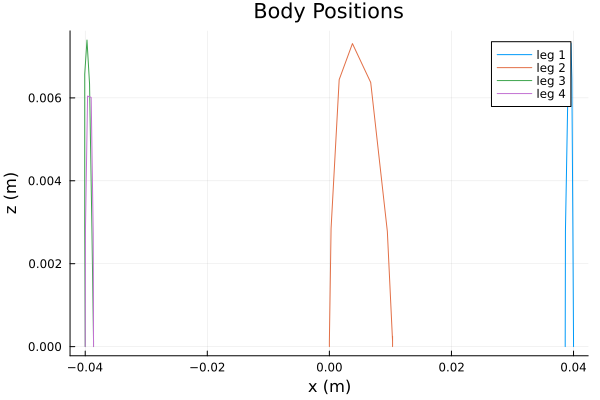

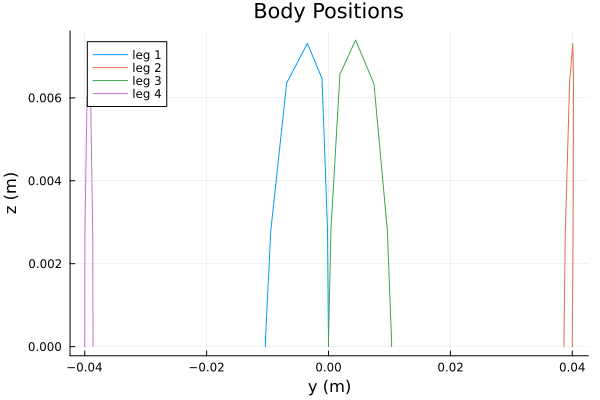

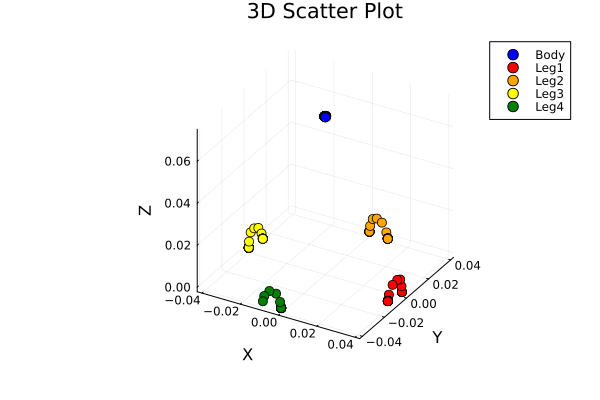

In [9]:

# plot(Xm[1,:],Xm[3,:], label = "body")
plot(Xm[4,:],Xm[6,:], label = "leg 1")
plot!(Xm[7,:],Xm[9,:], label = "leg 2")
plot!(Xm[10,:],Xm[12,:], label = "leg 3")
display(plot!(Xm[14,:],Xm[15,:], label = "leg 4",xlabel = "x (m)",
                ylabel = "z (m)", title = "Body Positions"))

# plot(Xm[2,:],Xm[3,:], label = "body")
plot(Xm[5,:],Xm[6,:], label = "leg 1")
plot!(Xm[8,:],Xm[9,:], label = "leg 2")
plot!(Xm[11,:],Xm[12,:], label = "leg 3")
display(plot!(Xm[14,:],Xm[15,:], label = "leg 4",xlabel = "y (m)",
                ylabel = "z (m)", title = "Body Positions"))

# colors = ["red","orange","yellow","green","blue","purple","red","orange","yellow","green","blue"]  # Generate random colors for each point
i = 0
scatter(Xm[i+1,:], Xm[i+2,:], Xm[i+3,:], markersize = 5, color = :blue, label = "Body")
scatter!(Xm[i+4,:], Xm[i+5,:], Xm[i+6,:], markersize = 5, color = :red, label = "Leg1")
scatter!(Xm[i+7,:], Xm[i+8,:], Xm[i+9,:], markersize = 5, color = :orange, label = "Leg2")
scatter!(Xm[i+10,:], Xm[i+11,:], Xm[i+12,:], markersize = 5, color = :yellow, label = "Leg3")
scatter!(Xm[i+13,:], Xm[i+14,:], Xm[i+15,:], markersize = 5, color = :green, label = "Leg4")
xlabel!("X")
ylabel!("Y")
zlabel!("Z")
title!("3D Scatter Plot")